# Project resolution of optical dataset onto microwave dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import xarray
import rasterio
import gdal

%matplotlib inline

In [2]:
mw_path = r"../Data/microwave-rs/CumJour-North-ssmi-1979-2022-H19.nc"
opt_path = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"

In [3]:
opt_path_out = r"../Data/optical-rs/optical-cropped/"

In [4]:
dataset_mw = xarray.open_dataset(mw_path).rio.write_crs(
    "epsg:3413", inplace=True
)  # add EPSG
dataset_mw = dataset_mw.where(
    dataset_mw["time"] == np.datetime64("2019-06-08"), drop=True
)  # only use one day for now
data_mw = dataset_mw["melt"]
data_opt = xarray.open_dataarray(opt_path)

In [5]:
data_mw.rio.to_raster("data_mw.tif")
data_omw_tif = xarray.open_dataarray("data_mw.tif")
data_omw_tif

<xarray.DataArray 'band_data' (band: 1, y: 109, x: 60)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Surface melt

In [6]:
# put to propper folder

In [7]:
def print_raster(raster):
    print(
        f"shape: \n   Y: {raster.rio.shape[0]} \n   X: {raster.rio.shape[1]}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: \n   minx = {raster.rio.bounds()[0]} \n   miny = {raster.rio.bounds()[1]} \n   maxx = {raster.rio.bounds()[2]} \n   maxy = {raster.rio.bounds()[3]}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )


print("Microwave TIF Raster:\n----------------")
print_raster(data_omw_tif)
print("Optical Raster:\n----------------")
print_raster(data_opt)

Microwave TIF Raster:
----------------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 358.0
CRS: EPSG:3413

Optical Raster:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



## Test

In [9]:
with rasterio.open("data_mw.tif") as src_mw:
    with rasterio.open(opt_path) as src_opt:
        opt_tif = src_opt.read(1)
        mw_tif = src_mw.read(1)
        upscaled_mw = np.zeros(opt_tif.shape)
        for row, col in np.argwhere(~np.isnan(mw_tif)):
            lon, lat = rasterio.transform.xy(
                src_mw.transform, row, col, offset="center"
            )
            row_temp, col_temp = rasterio.transform.rowcol(src_opt.transform, lon, lat)
            upscaled_mw[row_temp, col_temp] = 1

In [92]:
from rasterio.enums import Resampling

upscale_factor = 25
new_width = data_mw.rio.width * upscale_factor
new_height = data_mw.rio.height * upscale_factor

data_mw_upsampled = data_mw.rio.reproject(
    data_mw.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

del data_mw_upsampled.attrs["grid_mapping"]
data_mw_upsampled.rio.to_raster("data_mw_upsampled.tif")

c:\Users\ninaz\anaconda3\envs\my-env\lib\site-packages\rioxarray\raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [175]:
with rasterio.open("data_mw_upsampled.tif") as src_mw_upsampled:
    with rasterio.open("data_mw.tif") as src_mw:
        with rasterio.open(opt_path) as src_opt:
            upscaled_mw = np.zeros(src_mw_upsampled.shape)
            data_mw_full = xarray.open_dataset(mw_path).rio.write_crs(
                "epsg:3413", inplace=True
            )  # add EPSG
            for row, col in np.argwhere(~np.isnan(src_mw.read(1))):
                lon, lat = rasterio.transform.xy(
                    src_mw.transform, row, col, offset="center"
                )
                # bound= rasterio.transform.array_bounds(row, col,src_mw.transform)
                print(lon, lat)

                # row_new, col_new = rasterio.transform.rowcol(src_mw_upsampled.transform,lon,lat)
                # print(row, col, lon, lat)
            #    print(row, col, lon, lat)

-650000.0 -625000.0
-625000.0 -625000.0
-600000.0 -625000.0
-575000.0 -625000.0
-550000.0 -625000.0
-450000.0 -625000.0
-650000.0 -650000.0
-625000.0 -650000.0
-600000.0 -650000.0
-575000.0 -650000.0
-550000.0 -650000.0
-500000.0 -650000.0
-475000.0 -650000.0
-450000.0 -650000.0
-425000.0 -650000.0
-400000.0 -650000.0
-650000.0 -675000.0
-625000.0 -675000.0
-600000.0 -675000.0
-575000.0 -675000.0
-550000.0 -675000.0
-525000.0 -675000.0
-500000.0 -675000.0
-475000.0 -675000.0
-450000.0 -675000.0
-425000.0 -675000.0
-400000.0 -675000.0
-375000.0 -675000.0
-350000.0 -675000.0
-325000.0 -675000.0
125000.0 -675000.0
150000.0 -675000.0
175000.0 -675000.0
200000.0 -675000.0
-650000.0 -700000.0
-625000.0 -700000.0
-600000.0 -700000.0
-575000.0 -700000.0
-550000.0 -700000.0
-525000.0 -700000.0
-500000.0 -700000.0
-475000.0 -700000.0
-450000.0 -700000.0
-425000.0 -700000.0
-400000.0 -700000.0
-375000.0 -700000.0
-350000.0 -700000.0
-325000.0 -700000.0
75000.0 -700000.0
100000.0 -700000.0
125000.

In [ ]:
# VEDRANS CODE
"""
# manually upscale facebook data to same resolution
upscaled_fb = np.zeros(fb_resampled.shape)
for row, col in np.argwhere(fb > 0):
    # find lat long of the original point in the original raster
    lon, lat = rasterio.transform.xy(raster_trans,row,col,offset='center')
    # find the row col of the GPS point in the new reference system
    row, col = rasterio.transform.rowcol(resample_transform,lon,lat)
    # fill in the cell on the new raster
    #upscaled_fb[row,col] = 1
"""

## Attempt 10-11

1. shift
2. crop
3. duplicate optical dataset/ resample.
4. get coordinates for each pixel from opt
5. get values for each coordinate from old 
6. update values in opt copy

In [9]:
data_mw = xarray.open_dataset(mw_path).rio.write_crs("epsg:3413", inplace=True) # add EPSG
data_mw = data_mw.where(data_mw["time"] == np.datetime64('2019-06-08'), drop=True)["melt"] # only use one day for now
data_opt = xarray.open_dataarray(opt_path)

data_mw.rio.to_raster( 'data_mw_tif.tif')
data_omv_tif = xarray.open_dataarray('data_mw_tif.tif')

### 1. Shift

In [10]:
data_mw['x'] = [i+500 for i in data_mw['x']]
data_mw['y'] = [i-500 for i in data_mw['y']]

In [11]:
print('OPtical')
print_raster(data_opt)
print('MICROWAVE')
print_raster(data_mw)


OPtical
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413

MICROWAVE
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662000.0 
   miny = -3338000.0 
   maxx = 838000.0 
   maxy = -613000.0
sum: 358.0
CRS: EPSG:3413



### 2. Crop

In [12]:
cut_maxx= min(data_mw.rio.bounds()[2], data_opt.rio.bounds()[2])
cut_miny= max(data_mw.rio.bounds()[1], data_opt.rio.bounds()[1])
cut_minx= max(data_mw.rio.bounds()[0], data_opt.rio.bounds()[0])
cut_maxy= min(data_mw.rio.bounds()[3], data_opt.rio.bounds()[3])

In [13]:
# cut optical
overlap_window = (cut_minx,cut_maxy,cut_maxx,cut_miny)
gdal.Translate(opt_path_out + 'data_opt_cropped.tif', opt_path, projWin = overlap_window)



data_opt_cropped = xarray.open_dataarray(opt_path_out + 'data_opt_cropped.tif')
print_raster(data_opt_cropped)

shape: 
   Y: 2676 
   X: 1475
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3338000.0 
   maxx = 838000.0 
   maxy = -662000.0
sum: 324295.53125
CRS: EPSG:3413



### 3. Resample/ duplicacte optical dataset

### 4. get coord for each pixel in data_opt

In [ ]:
# add progress bar

In [35]:
# 4. get coordinates for each pixel from optical
# 5. get values for each coordinate from old 
# 6. update values in opt copy

zeros = np.zeros(data_opt.shape[1:]) # (2, 2)) #

with rasterio.open('data_mw.tif') as src_mw:
    with rasterio.open(opt_path) as src_opt:
        trans_opt = src_opt.transform
        data_opt_meta = src_opt.meta
        print(data_opt_meta)
        for row in range(data_opt.shape[1]): # 2):#
            for col in range(data_opt.shape[2]): # 2):#
                # get coord from optical:
                lon, lat = rasterio.transform.xy(trans_opt,row,col,offset='center') # maybe use upscaled mw 
                # get value from mw dataset:
                val = list(src_mw.sample([(lon, lat)]))[0][0]
                # write values to matrix:
                zeros[row][col] = val
                #print(val)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1487, 'height': 2687, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(1000.0, 0.0, -637000.0,
       0.0, -1000.0, -662000.0)}


In [ ]:
#maybe write just not 0 and not nan???

In [46]:
# 315 min
# save that matrix just in case
#np.isnan(np.min(zeros))
zeros[np.isnan(zeros)] = -1
np.savetxt('mw_val_matrix.csv', zeros, fmt="%d", delimiter=",")

In [52]:
zeros[zeros == -9999] = -1

In [57]:
zeros.min()

-1.0

In [47]:
# create copy of cropped opt data, update values with zeros matrix and write to mw folder
# nope
# write new file to folder containing new mw data in opt shape

In [65]:
# Write to TIFF
kwargs = data_opt_meta
kwargs.update(
    dtype=rasterio.float32,
    count=1#,    compress='lzw'
    ) # transform same???
    

In [66]:
with rasterio.open('out_new_band.tif', 'w', **kwargs) as dst:
    dst.write_band(1, zeros.astype(rasterio.float32))

In [67]:
data_mw_fine= xarray.open_dataarray('out_new_band.tif')

In [68]:
data_mw_fine.min()

<xarray.DataArray 'band_data' ()>
array(-1., dtype=float32)
Coordinates:
    spatial_ref  int64 ...

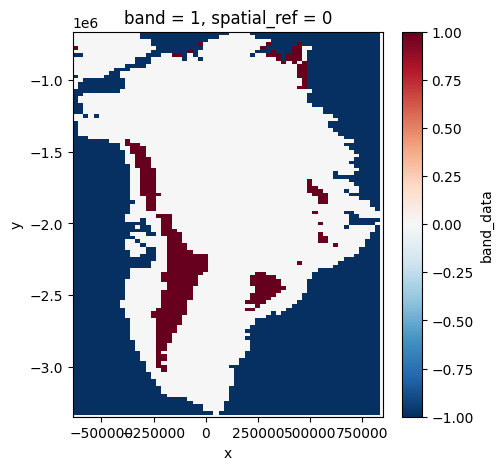

In [69]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
data_mw_fine.plot(ax=axes)
#data_opt.plot(ax=axes[1])
plt.draw()

In [ ]:
# for next iterations:

# copy this dataset, make all 0 and -1 - initialize matrix like this. update only values == 1

### 7. delete stuff?

In [ ]:
# delete craeted shit?